# Results
In this notebook, we define and calculate the statistics of our tests.

In [3]:
# load data

import json
import pandas as pd
from collections import defaultdict
import math
import os
# dirName = "results"

# def loadData():
#     data = {}
#     for content in os.listdir(dirName):
#         contentPath = os.path.join(dirName,content)
#         if os.path.isfile(contentPath) and ".json" in content:
#             with open(contentPath, "r", encoding='utf-8') as file:
#                 data = {**data,**json.loads(file.read().replace("$",""))}

#     raiseError = False
#     for caseNum, case in data.items():
#         if len(case) != 9:
#             raiseError = True 
#             print(f"Case {caseNum} has only {sorted(list(case.keys()))}")

#     if raiseError:
#         raise ValueError
    
#     for case in data.values():
#         for app, result in case.items():
#             case[app] = [r for r in result if r]
    
#     return data

def normalize(cases):
    for case in cases.values():
        maxLen = max(len(result) for result in case.values())
        for result in case.values():
            result += [None]*(maxLen-len(result))

        assert len(set(len(result) for result in case.values())) == 1
    
    return cases

def getDataframe(case):
    return pd.DataFrame(
        case,
        columns=["gs",*sorted([key for key in case.keys() if key != "gs"])],
        index= list(range(1,1+len(list(case.values())[0])))
        )


In [8]:
data = loadData()
normalizedData = normalize(data)
cases = {id: getDataframe(case) for id, case in normalizedData.items()}
print(len(cases))
list(cases.items()).pop()


437


('51',
                gs              Ada Babylon                       Buoy  \
 1  hypothyroidism   hypothyroidism  no ddx  polycystic ovary syndrome   
 2     thyroiditis  mild depression    None             hypothyroidism   
 3            None          burnout    None                 depression   
 4            None             None    None                       None   
 5            None             None    None                       None   
 
          K health            Mohmmad Almadani     Noor Joudeh  \
 1  hypothyroidism              hypothyroidism  hypothyroidism   
 2     thyroiditis           pituitary adenoma            None   
 3            None   antidepressant medication            None   
 4            None  antihypertensve midication            None   
 5            None                        None            None   
 
         Tala Hammouri                      WebMD  
 1      hypothyroidism    obstructive sleep apnea  
 2  hyperprolactinemia  seasonal depression (

## Let us define the metrics now.

### Terms used
- TP: True positive (correct disease retrieved)
- TN: True negative (wrong disease **not** retrieved)
- FP: False positive (wrong disease retrieved)
- FN: False negative (correct disease **not** retrieved)
- gold standard - the correct list of diseases as determined by collective intelligence of doctors

### Precision
Precision helps us understand how exact our results are. It gives us an intuition about how many wrong diseases (false positives) are being retrieved. It is the ratio *number of correct diseases retrieved* to the *length of the complete list retrieved*.
$$precision = \frac{TP}{TP + FP} = \frac{TP}{\text{length of differential list}}$$

### Recall
Recall is a measure of how many of the correct diseases are being retrieved. It is the ratio *number of correct diseases retrieved* to the *length of the gold standard list*.
$$recall = \frac{TP}{TP + FN} = \frac{TP}{\text{length of the gold standard}}$$

### F1 Score
F1 score is the weighted harmonic mean of *precision* and *recall*. It is a metric that combines *precision* and *recall* and gives us 1 score for easier comparison.

Suppose $\beta$ defines how important is $recall$ to $precision$ then,
$$fscore_{\beta} = (1 + \beta^2)\frac{precision \cdot recall}{(\beta^2 \cdot precision) + recall}$$
Substituting $\beta = 1$,
$$fscore_{1} = \frac{2 \cdot precision \cdot recall}{ precision + recall}$$

### NDCG
NDCG or Normalized Discounted Cumulative Gain is measure of how accurate the ranking is. In our calculations, we use
$$DCG = \sum_{i=1}^n\frac{2^{relevance_i}-1}{log_2(i+1)}$$
where $n$ is the number of differentials in the returned list and  
$relevance_i = |gold standard| - rank_{gold\ standard}(ddx[i])$ if $ddx[i]$ is present, 0 otherwise.

$$NDCG = \frac{DCG_{ddx}}{DCG_{gold\ standard}}$$

### M Score
M Score determines where the top disease (gold standard) appears in the returned differential.
$$M_i = \text{gold standard[0]} \in \text{ddx[:i]}$$

### Position
Shows the position of the gold standard[0] in the returned differential. 

### Length
$$length = \frac{|ddx|}{|gold\ standard|}$$


In [5]:
import math

beta = 1

def getPrecision(goldStandard: pd.Series, candidate: pd.Series) -> float:
    tp = sum(int(disease in goldStandard.values and disease is not None)
             for disease in candidate)
    return tp if tp == 0 else tp/candidate.count()


def getRecall(goldStandard: pd.Series, candidate: pd.Series) -> float:
    tp = sum(int(disease in goldStandard.values and disease is not None)
             for disease in candidate)
    return tp/goldStandard.count()


def getF1Score(precision: float, recall: float, beta: float = 1) -> float:
    return math.nan if precision+recall == 0 else \
        (1+beta**2)*precision*recall/(precision*(beta**2)+recall)


def getNDCG(goldStandard: pd.Series, candidate: pd.Series, scores) -> float:
    def discount(score: float, index: int) -> float:
        return (math.pow(2, score)-1)/math.log2(index+1)

    maxDCG = sum(discount(scores[i], i+1) for i in range(len(scores)))

    candidateRelevance = []
    for index, disease in enumerate(candidate):
        goldStandard = list(goldStandard)
        if disease is not None and disease in goldStandard:
            candidateRelevance.append(
                discount(scores[goldStandard.index(disease)], index+1))
        else:
            candidateRelevance.append(0)

    return sum(candidateRelevance)/maxDCG


def getMScore(goldStandard: pd.Series, candidate: pd.Series, m=1) -> bool:
    return goldStandard.values[0] in candidate.values[:m]


def getPosition(goldStandard: pd.Series, candidate: pd.Series) -> bool:
    return math.nan if goldStandard.values[0] not in candidate.values else\
        1 + list(candidate.values).index(goldStandard.values[0])


def getLength(goldStandard: pd.Series, candidate: pd.Series) -> int:
    return math.nan if candidate.count() == 0 else \
        candidate.count()/goldStandard.count()


def getScoresCase(case: pd.DataFrame, beta:float = 1) -> pd.DataFrame:
    scores = [
        [getPrecision(case.iloc[:, 0], case.iloc[:, i])
         for i in range(1, len(case.columns))],
        [getRecall(case.iloc[:, 0], case.iloc[:, i])
         for i in range(1, len(case.columns))]
    ]

    scores.append([getF1Score(scores[0][i], scores[1][i],beta=beta)
                  for i in range(len(case.columns)-1)])
    scores.append([getNDCG(case.iloc[:, 0], case.iloc[:, i],
                           list(range(case.iloc[:, 0].count(), 0, -1)))
                   for i in range(1, len(case.columns))])

    for m in range(1, 6, 2):
        scores.append([getMScore(case.iloc[:, 0], case.iloc[:, i], m)
                      for i in range(1, len(case.columns))])

    scores.append([getPosition(case.iloc[:, 0], case.iloc[:, i])
                   for i in range(1, len(case.columns))])

    scores.append([getLength(case.iloc[:, 0], case.iloc[:, i])
                   for i in range(1, len(case.columns))])

    return pd.DataFrame(scores, columns=case.columns[1:],
                        index=["precision", "recall", "f1-score", "NDCG",
                               "M1", "M3", "M5", "position", "length (x of gs)"],
                        )

scores = {id:getScoresCase(case) for id, case in cases.items()}

In [6]:
def getAverage(scores, row: int, col: int) -> float:
    values = []
    for score in scores.values():
        if not math.isnan(score.iloc[row, col]):
            values.append(score.iloc[row, col])

    return 0 if not values else round(sum(values)/len(values), 3)


averageScores = pd.DataFrame(
    [
        [
            getAverage(scores, row, col)
            for col in range(len(next(iter(scores.values())).columns))
        ]
        for row in range(9)
    ],
    columns=next(iter(scores.values())).columns,
    index=[
        f"average_{x}" for x in [
            "precision", "recall", "f1-score", "NDCG", "M1", "M3", "M5", "position", "length (x of gs)"
        ]
    ]
)

# ignore nan for recall
for col in next(iter(scores.values())).columns:
    p = averageScores.loc["average_precision", col]
    r = averageScores.loc["average_recall", col]
    averageScores.loc["average_f1-score",
                      col] = round(getF1Score(p, r, beta), 3)

doctorResults = averageScores.loc[:, "Mohmmad Almadani"] +\
    averageScores.loc[:, "Noor Joudeh"] +\
    averageScores.loc[:,
                        "Tala Hammouri"]
doctorResults /= 3.0
# print("average_doctor" in averageScores.columns)
averageScores.insert(
    loc=7, column="average_doctor",
    value=doctorResults.round(3),
)

averageScores
# doctorResults


,Ada,Babylon,Buoy,K health,Mohmmad Almadani,Noor Joudeh,Tala Hammouri,average_doctor,WebMD
average_precision,0.437,0.031,0.291,0.302,0.569,0.773,0.713,0.685,0.214
average_recall,0.563,0.019,0.278,0.334,0.395,0.397,0.552,0.448,0.432
average_f1-score,0.492,0.024,0.284,0.317,0.466,0.525,0.622,0.538,0.286
average_NDCG,0.617,0.022,0.323,0.351,0.513,0.575,0.723,0.604,0.396
average_M1,0.526,0.021,0.268,0.275,0.490,0.613,0.721,0.608,0.249
average_M3,0.707,0.023,0.403,0.382,0.622,0.677,0.876,0.725,0.416
average_M5,0.757,0.025,0.403,0.407,0.629,0.680,0.879,0.729,0.513
average_position,1.544,1.364,1.432,1.631,1.295,1.125,1.229,1.216,2.232
average_length (x of gs),1.526,0.524,1.014,1.243,0.866,0.561,0.884,0.770,2.241


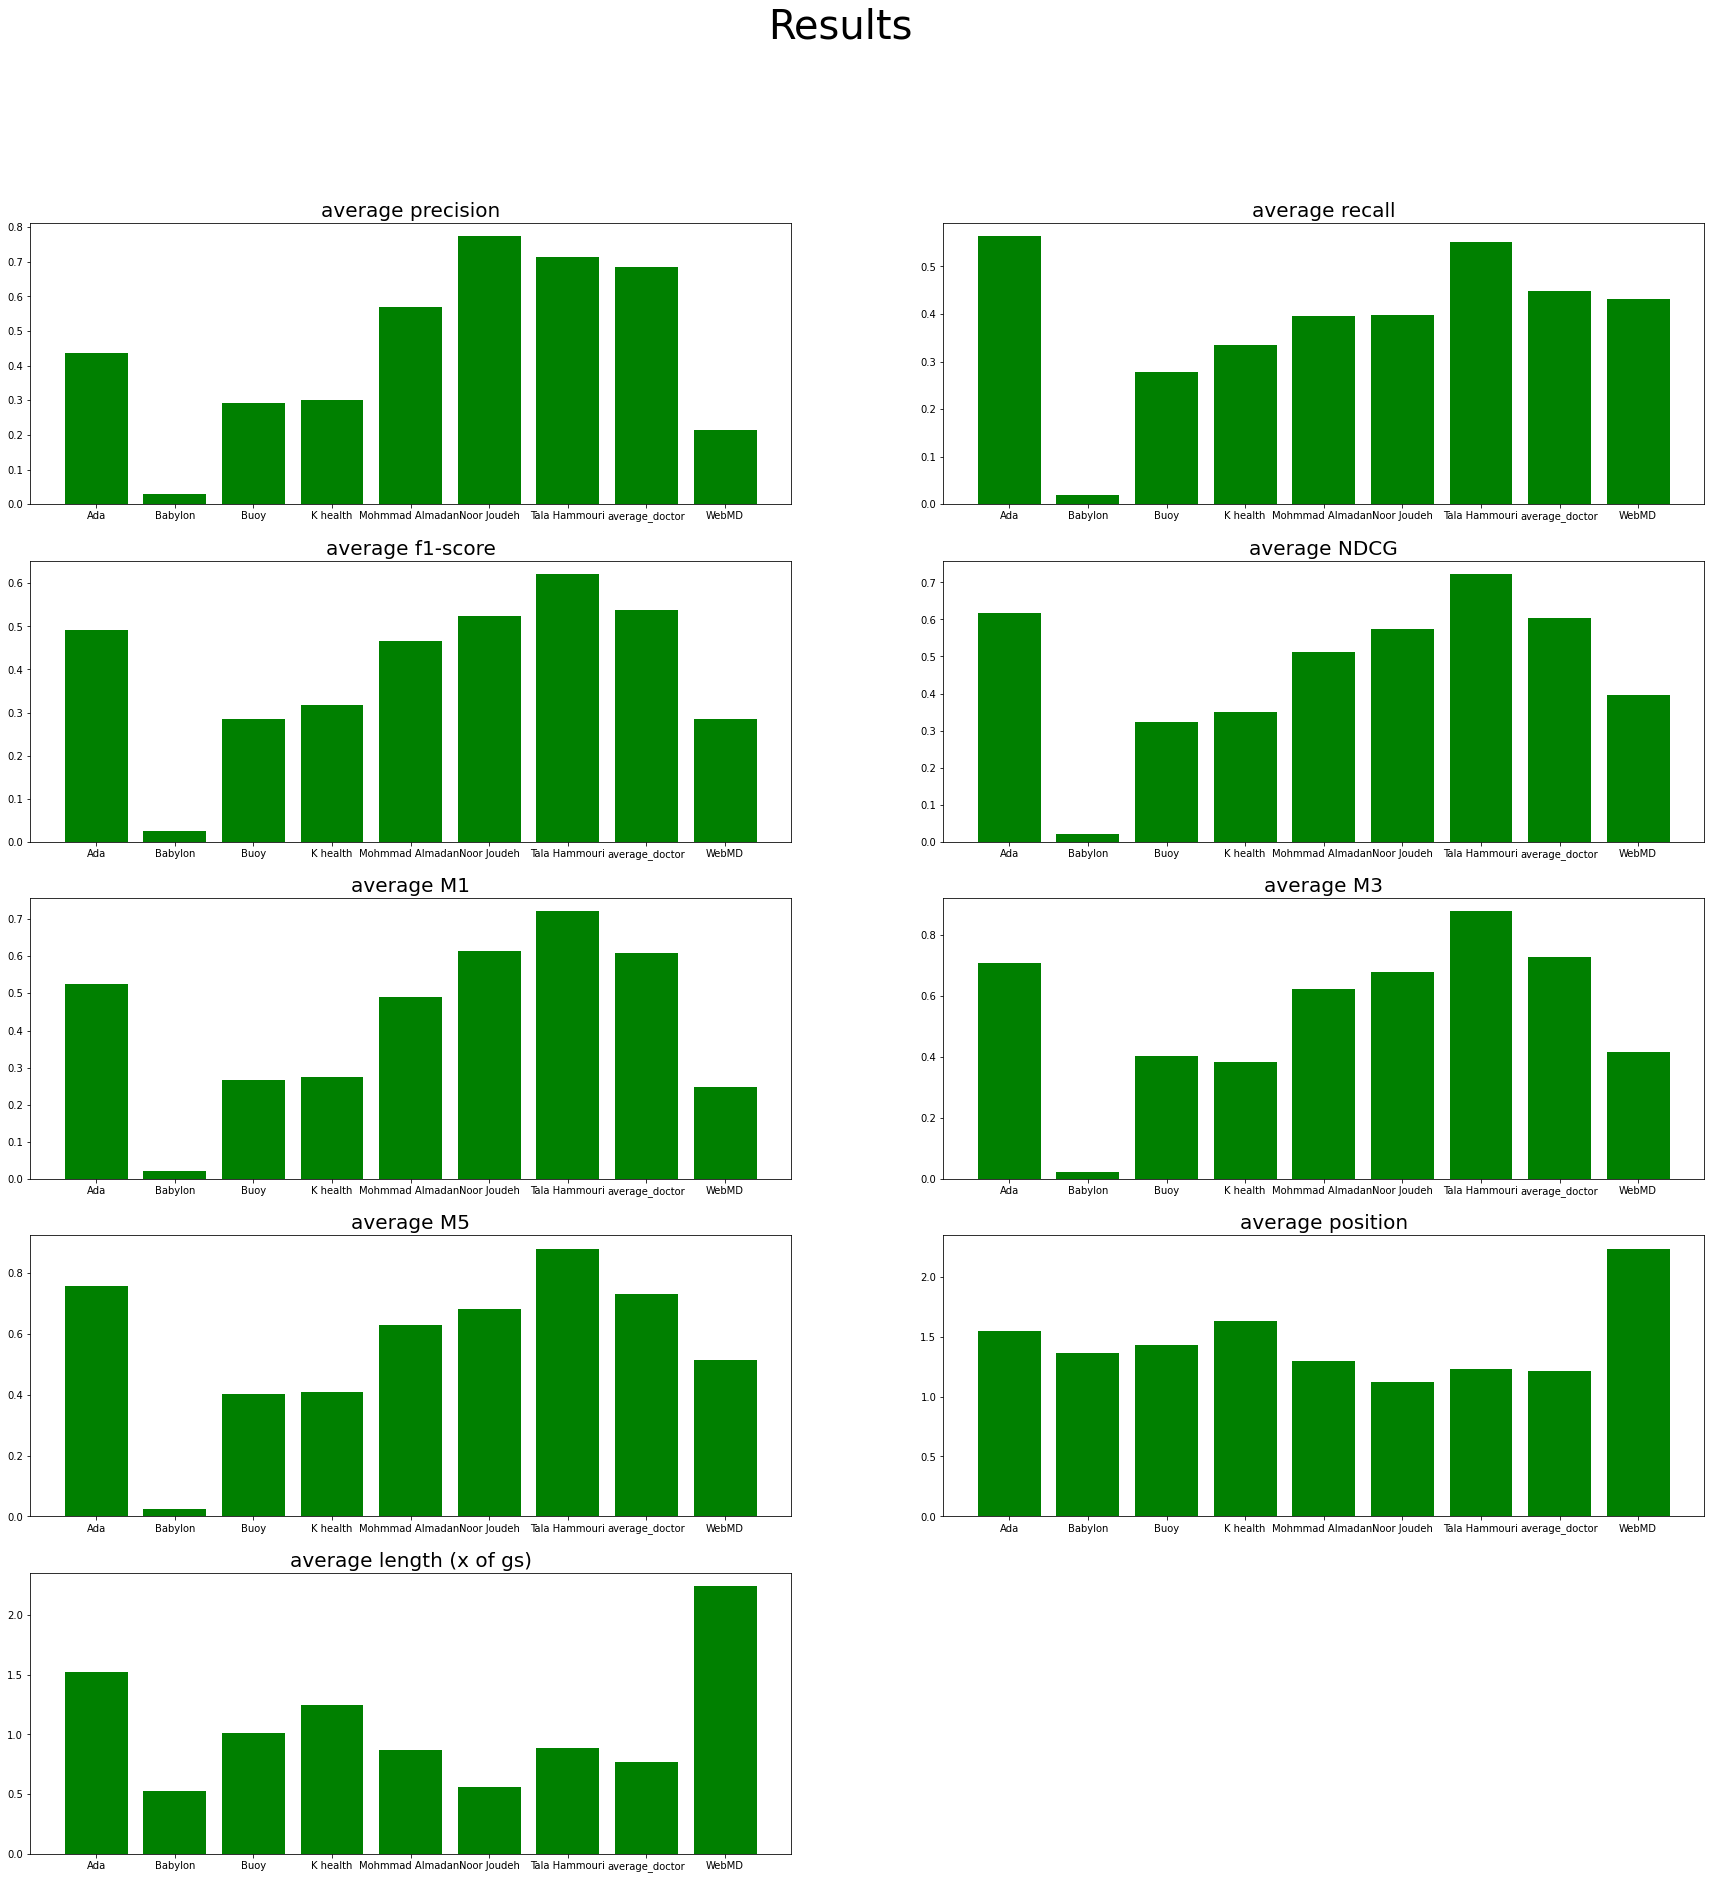

In [7]:
import matplotlib.pyplot as plt
import math

scoresToCompare = pd.DataFrame(averageScores,columns=averageScores.columns)

fig, subplots = plt.subplots(5,2, figsize=(30,30))
fig.suptitle("Results",fontsize=40)

for index, metric in enumerate(scoresToCompare.index.values.tolist()):
    subplots[index//2, index %
             2].bar(scoresToCompare.columns, averageScores.loc[metric],color="green")
    subplots[index//2, index % 2].set_title(metric.replace("_"," "),fontsize=20)


fig.delaxes(subplots[4,1])
plt.show()
averageScores.to_csv(path_or_buf="results.csv",sep=";")
